# Analysing Reliability of DOSPERT answers 20 LLMs

- We want to measure, for each LLM, how consistent it is in assigning probabilities across the 40-item answer patterns of a single human. Essentially: “Does the LLM consistently see the human’s answer pattern as more or less probable, or is it erratic?”

In [ ]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pingouin as pg
import seaborn as sns

# Initialize empty list to store DataFrames
dospert_dataframes = []

path = "outputs"  # folder with CSVs

for file in glob.glob(os.path.join(path, "*_dospert_scores.csv")):
    model_name = os.path.basename(file).replace("_dospert_scores.csv", "")
    
    # Read the CSV
    df = pd.read_csv(file)
    
    # Append to list
    dospert_dataframes.append(df)
    
# Concatenate all DataFrames into one big DataFrame
merged_dospert_data = pd.concat(dospert_dataframes, ignore_index=True)

print(f"\nMerged DataFrame shape: {merged_dospert_data.shape}")
print(f"Total models: {merged_dospert_data['model'].nunique()}")
print(f"Models included: {sorted(merged_dospert_data['model'].unique())}")

# add column with predicted logprob for actual human answers
# merged_dospert_data['logprob_predicted'] = merged_dospert_data.apply(
#     lambda row: row[str(row['human_number'])], axis=1
# )




# Define mapping dictionary
item_to_category = {
    1: "Social", 10: "Social", 16: "Social", 19: "Social", 23: "Social", 26: "Social", 34: "Social", 35: "Social",
    2: "Recreational", 6: "Recreational", 15: "Recreational", 17: "Recreational", 21: "Recreational", 31: "Recreational", 37: "Recreational", 38: "Recreational",
    3: "Gambling", 11: "Gambling", 22: "Gambling", 33: "Gambling",
    4: "Health", 8: "Health", 27: "Health", 29: "Health", 32: "Health", 36: "Health", 39: "Health", 40: "Health",
    5: "Ethical", 9: "Ethical", 12: "Ethical", 13: "Ethical", 14: "Ethical", 20: "Ethical", 25: "Ethical", 28: "Ethical",
    7: "Investment", 18: "Investment", 24: "Investment", 30: "Investment"
}

# Add a new column "domain"
merged_dospert_data["domain"] = merged_dospert_data["item"].map(item_to_category)

# Check column names
print(f"\nColumns: {list(merged_dospert_data.columns)}")



Merged DataFrame shape: (1208800, 11)
Total models: 20
Models included: ['Falcon-3-10B-Instruct', 'Falcon-3-1B-Instruct', 'Falcon-3-7B-Instruct', 'Llama-3.1-8B-Instruct', 'Llama-3.2-1B-Instruct', 'Llama-3.2-3B-Instruct', 'Ministral-8B-Instruct-2410', 'Mistral-7B-Instruct-v0.3', 'OLMo-2-7B-Instruct', 'Qwen3-1.7B', 'Qwen3-4B', 'Qwen3-8B', 'SmolLM-1.7B-Instruct', 'SmolLM2-1.7B-Instruct', 'Unsloth-Qwen3-1.7B', 'gemma-2-2b-it', 'gemma-2-9b-it', 'gemma-3-1b-it', 'gemma-3-4b-it', 'zephyr-7b-beta']

Columns: ['human_number', '1', '2', '3', '4', '5', 'model', 'item', 'participant', 'flipped', 'experiment', 'domain']


In [ ]:
# ---- Calc Probability for human answer normalized over answer alternatives ----

logprob_cols = ['1', '2', '3', '4', '5']

# Step 1: Convert log-probs to probabilities
# We exponentiate the log probabilities
prob_matrix = np.exp(merged_dospert_data[logprob_cols].values)

# Step 2: Normalize so that each row sums to 1
prob_matrix = prob_matrix / prob_matrix.sum(axis=1, keepdims=True)

# Step 3: Add new columns for each normalized probability
for i, col in enumerate(logprob_cols):
    merged_dospert_data[f'prob_{col}'] = prob_matrix[:, i]

# Step 4: Extract probability of actual human choice
# 'human_number' is 1-indexed; need to subtract 1 for zero-based indexing
merged_dospert_data['logprob_predicted'] = prob_matrix[np.arange(len(merged_dospert_data)), merged_dospert_data['human_number'] - 1]


# Step 3: Extract the probability of the actual human choice
#merged_dospert_data['logprob_predicted'] = prob_matrix[np.arange(len(merged_dospert_data)), merged_dospert_data['human_number'] - 1]


In [ ]:
merged_dospert_data[merged_dospert_data['model']=="zephyr-7b-beta"] # simply all probabilities equally likely, no variance!
merged_dospert_data[merged_dospert_data['model']=="Mistral-7B-Instruct-v0.3"] # simply all probabilities equally likely, no variance!
merged_dospert_data.groupby("model")["logprob_predicted"].nunique()

model
Falcon-3-10B-Instruct         47541
Falcon-3-1B-Instruct          45601
Falcon-3-7B-Instruct          29348
Llama-3.1-8B-Instruct         32372
Llama-3.2-1B-Instruct         23752
Llama-3.2-3B-Instruct         33546
Ministral-8B-Instruct-2410    50767
Mistral-7B-Instruct-v0.3          2
OLMo-2-7B-Instruct            30153
Qwen3-1.7B                    30612
Qwen3-4B                      27118
Qwen3-8B                      41017
SmolLM-1.7B-Instruct          32359
SmolLM2-1.7B-Instruct         22542
Unsloth-Qwen3-1.7B            30612
gemma-2-2b-it                 47484
gemma-2-9b-it                 45241
gemma-3-1b-it                 47577
gemma-3-4b-it                 47861
zephyr-7b-beta                    2
Name: logprob_predicted, dtype: int64

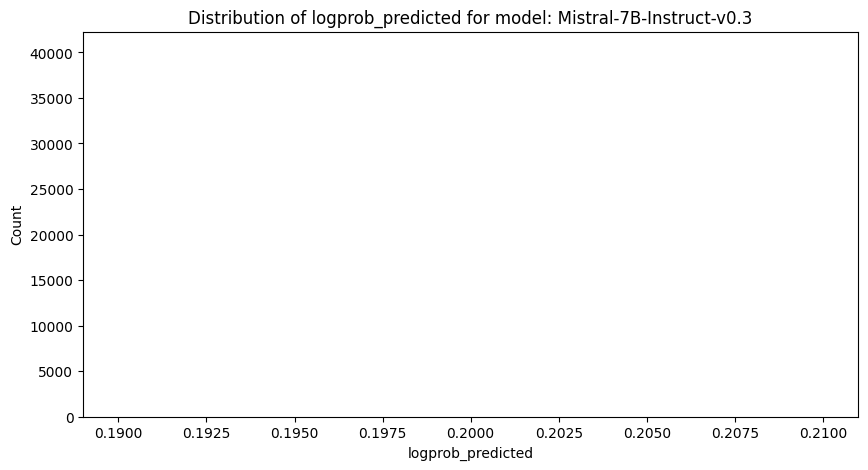

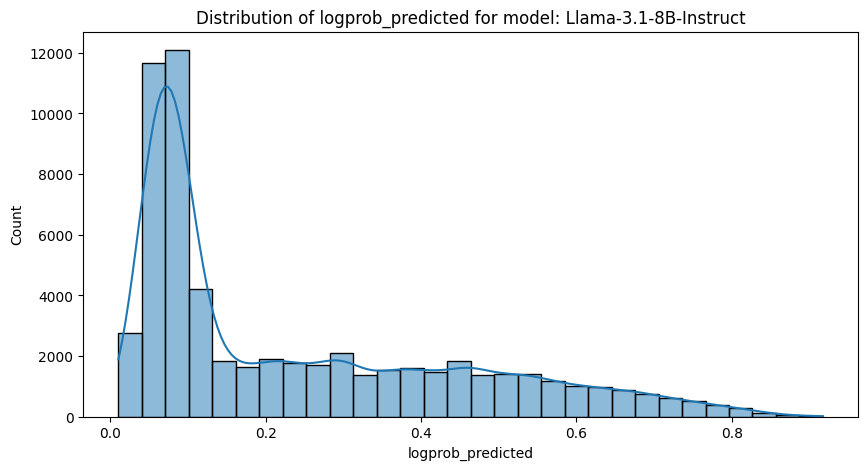

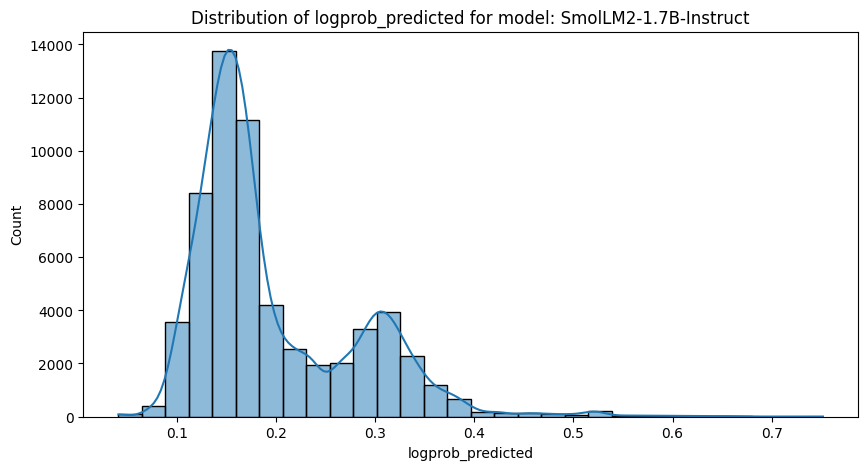

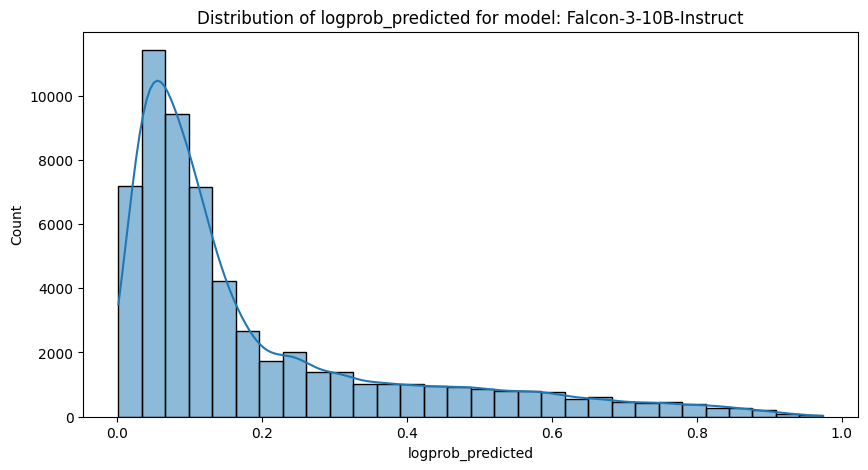

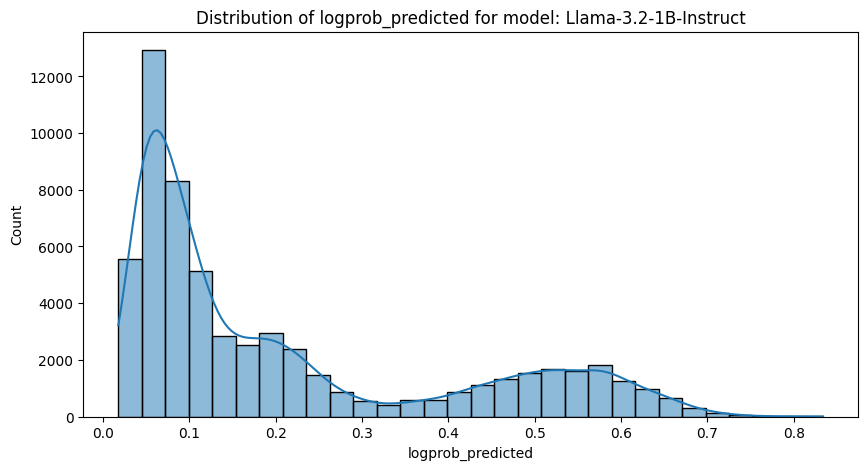

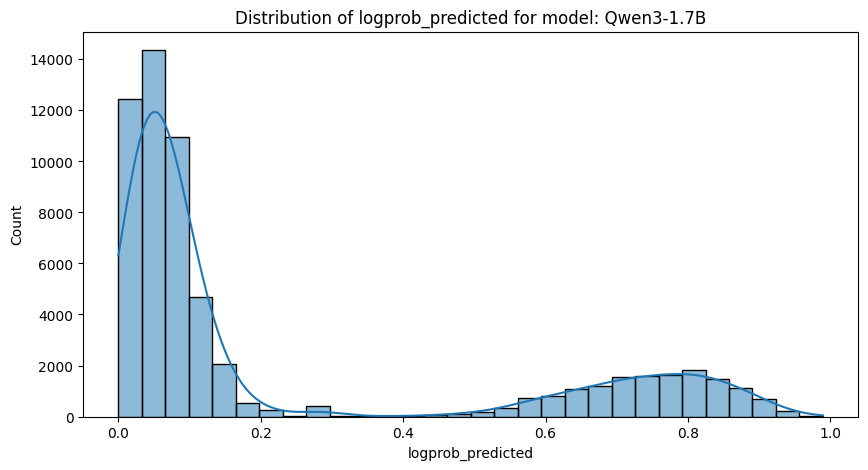

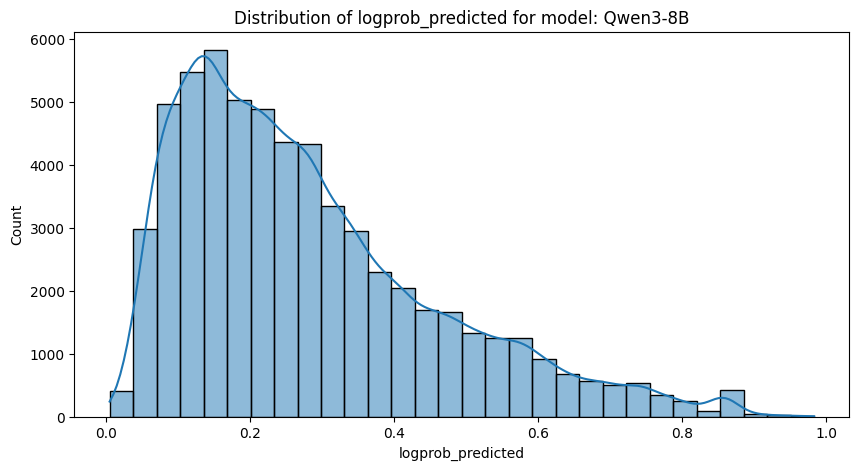

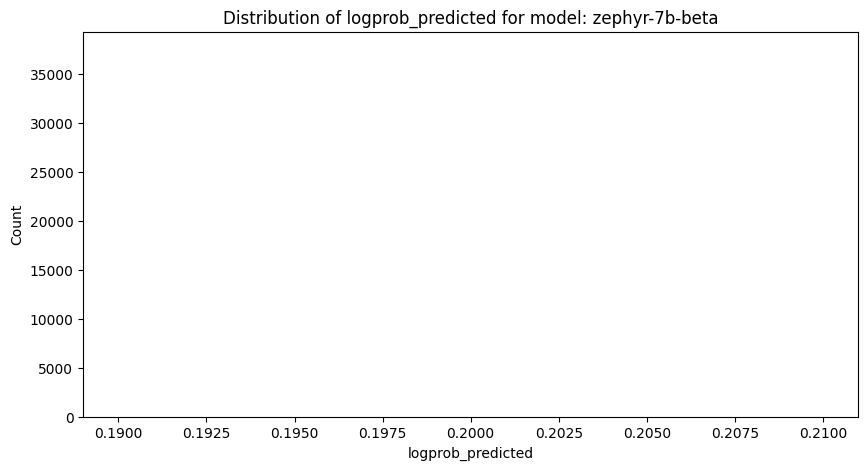

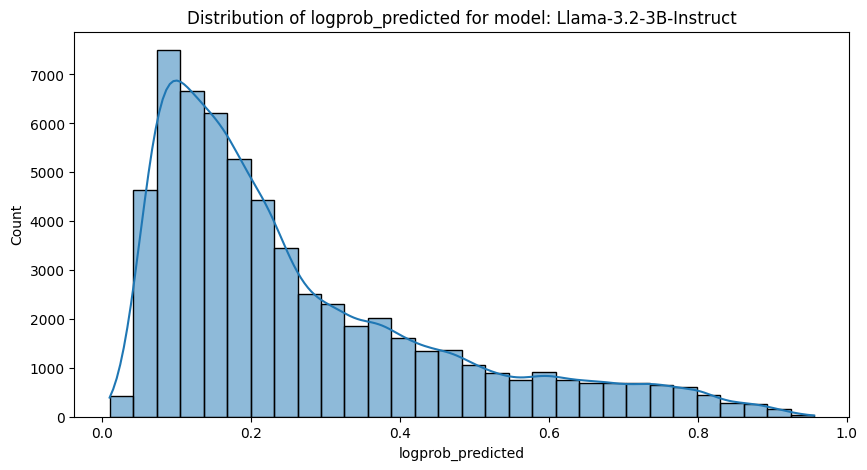

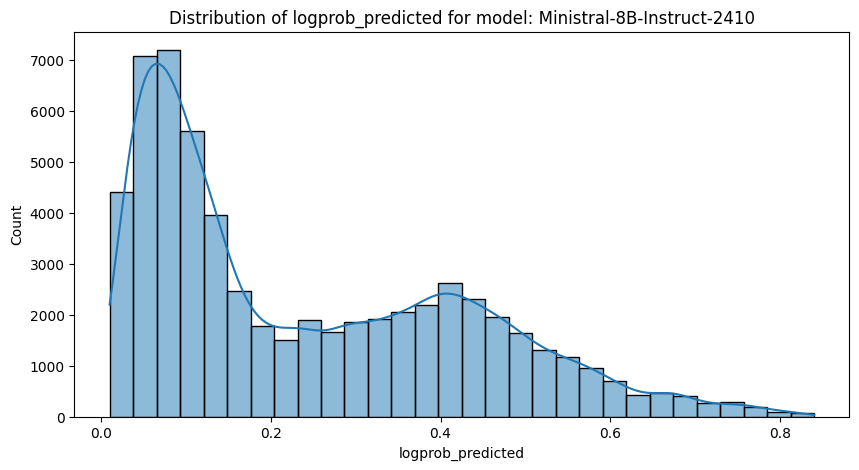

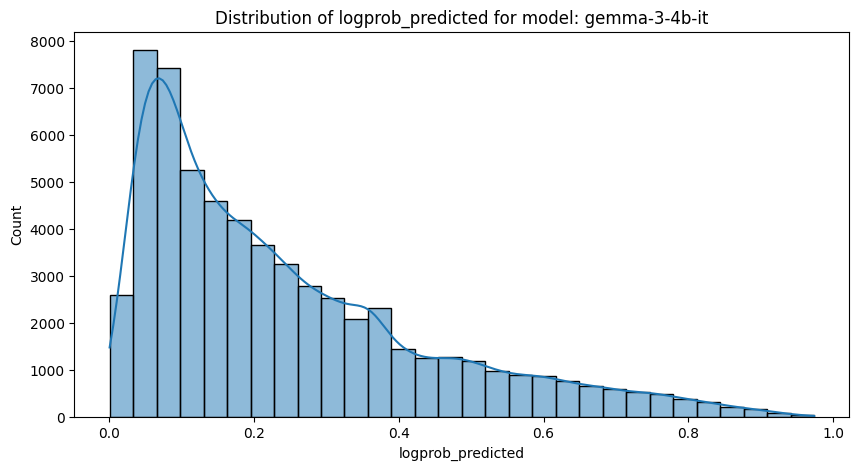

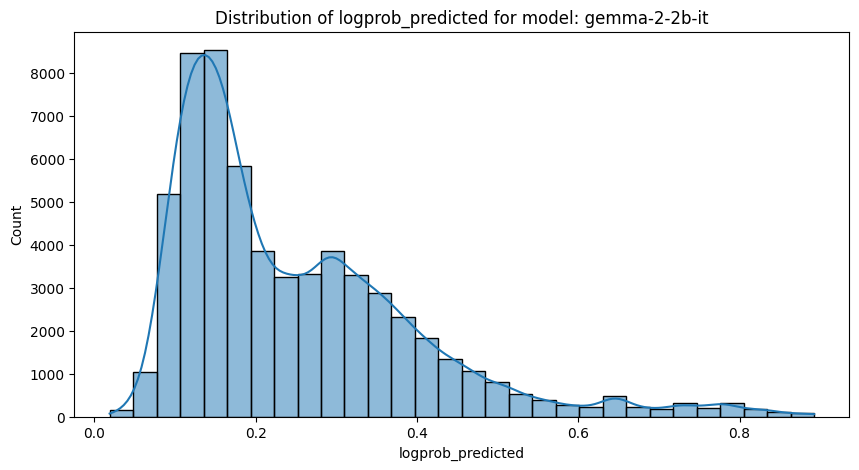

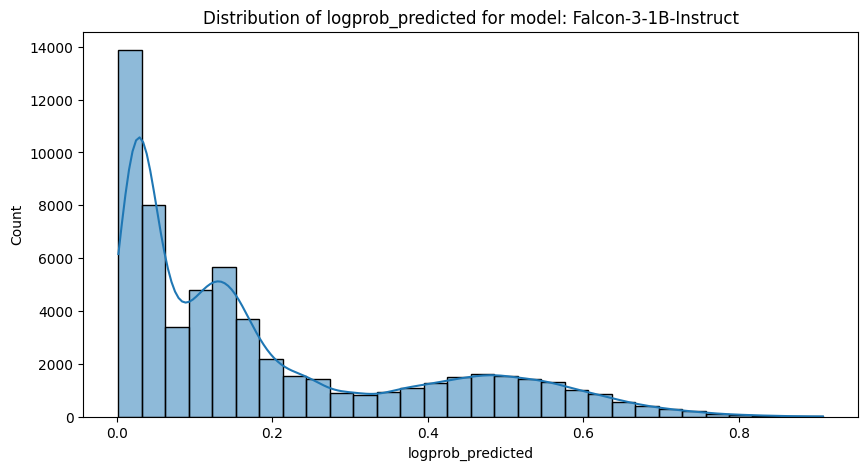

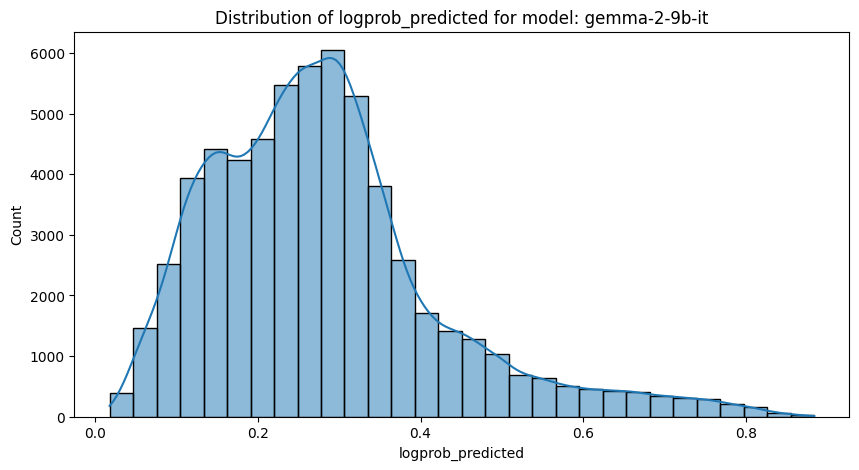

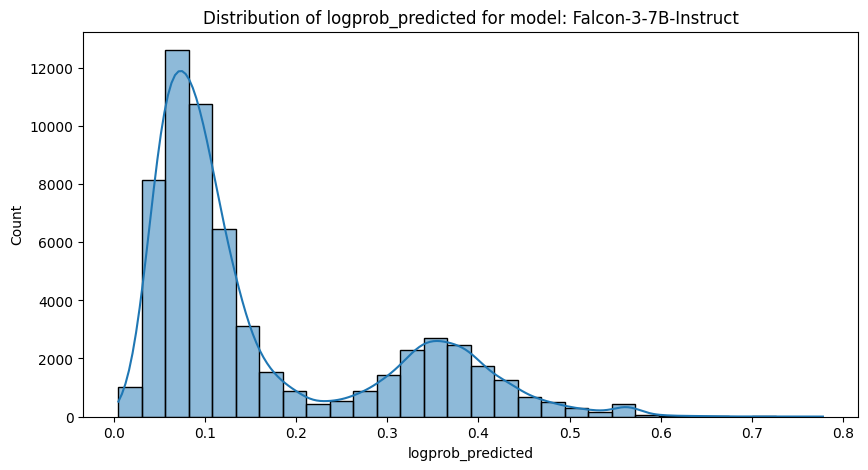

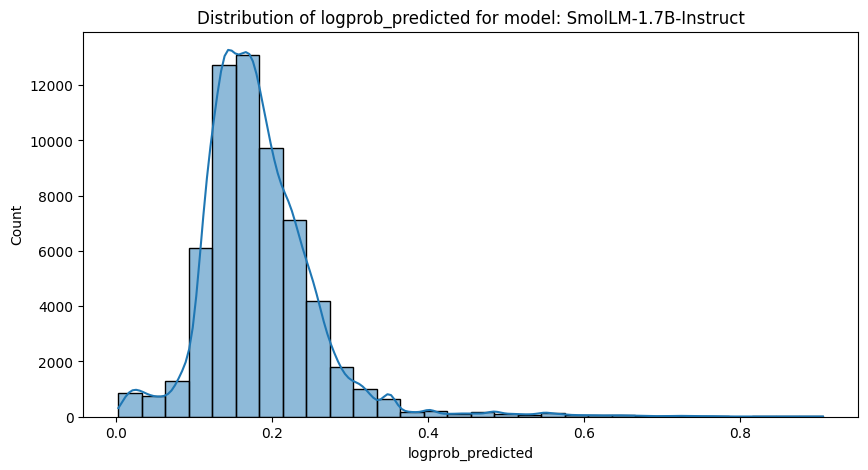

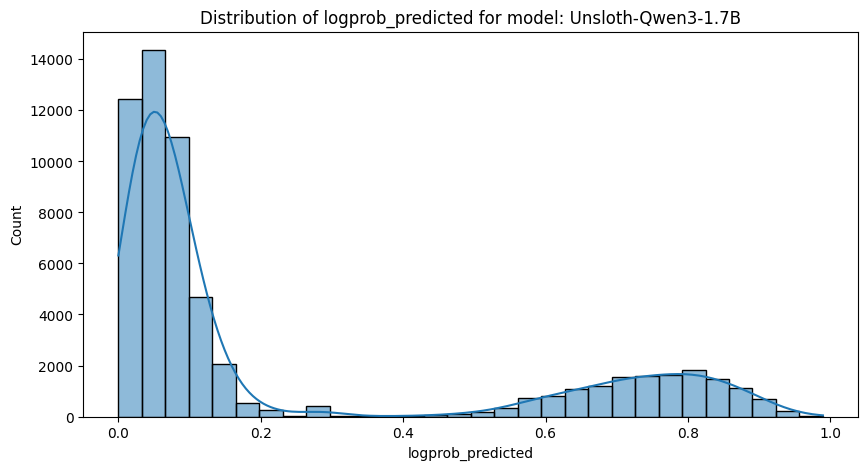

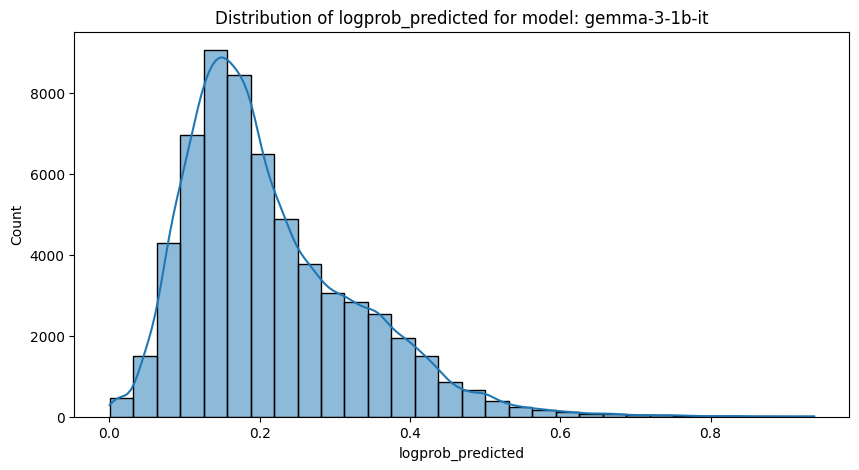

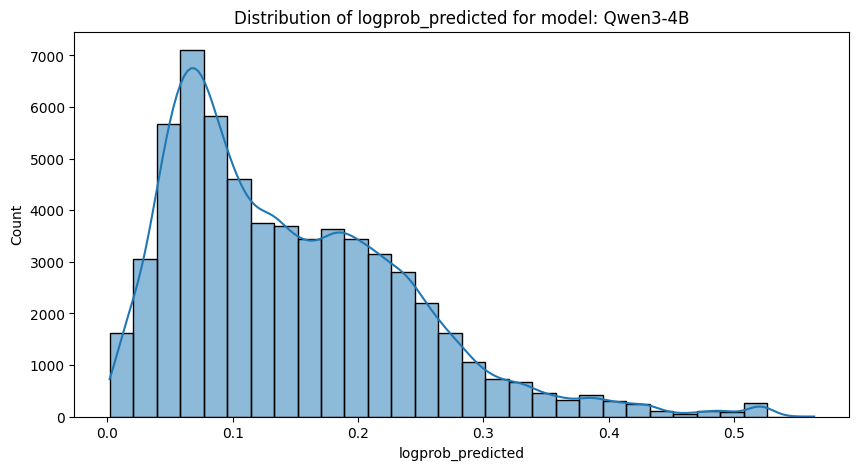

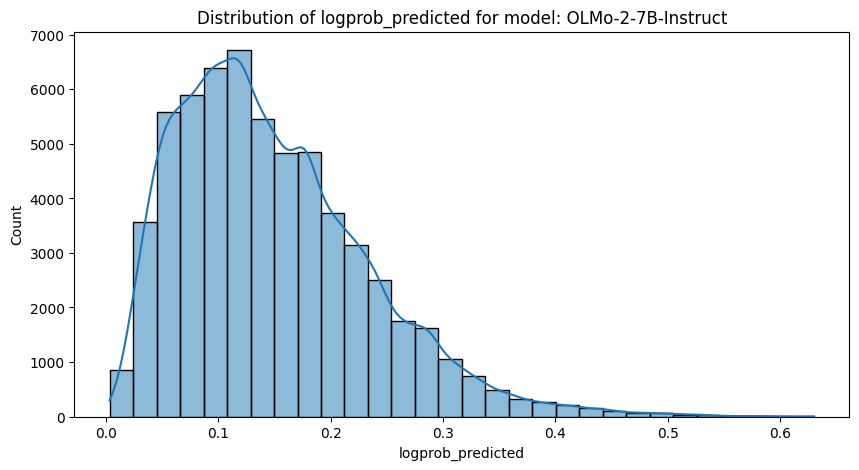

In [109]:
# Visualise distribution (focus on variance) per model of logprobs

model_names = merged_dospert_data['model'].unique()

for model_name in model_names:
    df_plot = merged_dospert_data[merged_dospert_data['model'] == model_name]
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_plot, x="logprob_predicted", kde=True, bins=30)  # KDE optional
    plt.title(f'Distribution of logprob_predicted for model: {model_name}')
    plt.xlabel('logprob_predicted')
    plt.ylabel('Count')
    plt.show()

In [94]:
# ---- Cronbach's alpha per domain ----

# dictionary to store results
results = []

# loop through domains
for domain, domain_data in merged_dospert_data.groupby("domain"):
    
    # loop through models within this domain
    for model, model_data in domain_data.groupby("model"):
        
        # pivot wide format for Cronbach's alpha
        df_wide_domains = model_data.pivot_table(
            index="participant",
            columns="item",
            values="logprob_predicted"
        )
        
        # drop rows with missing data
        df_wide_domains = df_wide_domains.dropna(axis=0)
        
        # calculate Cronbach's alpha
        if df_wide_domains.shape[1] > 1:  # need at least 2 items
            alpha, ci = pg.cronbach_alpha(df_wide_domains)
        else:
            alpha, ci = None, (None, None)  # not enough items to compute
        
        # store results
        results.append({
            "domain": domain,
            "model": model,
            "alpha": alpha,
            "alpha_CI": ci
        })

# convert to DataFrame
alpha_df = pd.DataFrame(results)


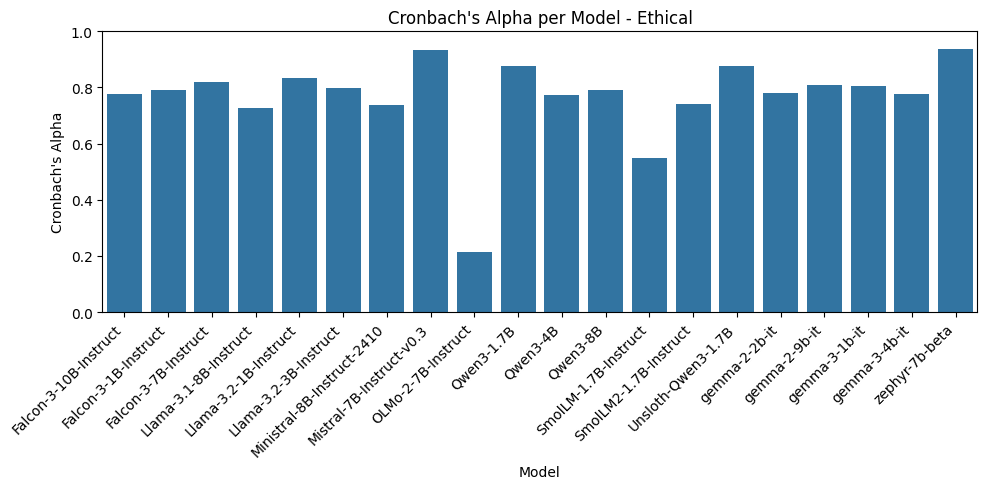

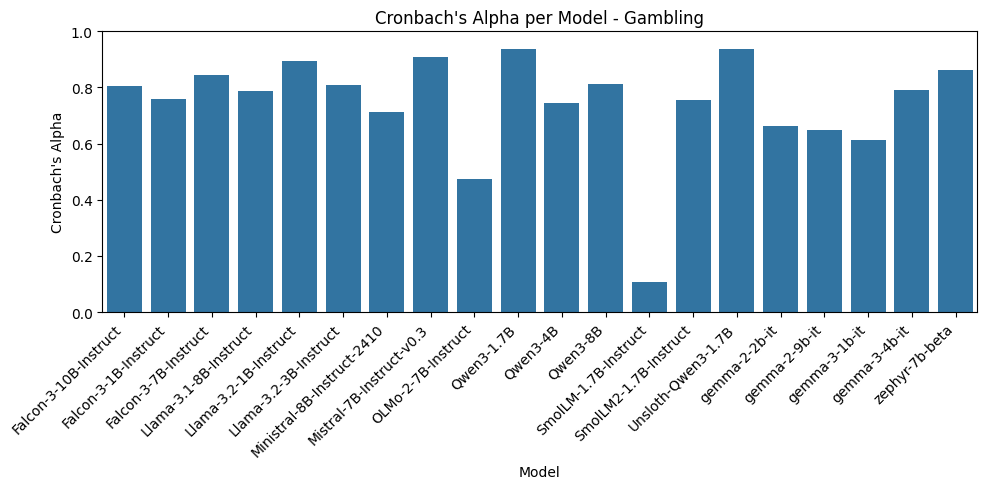

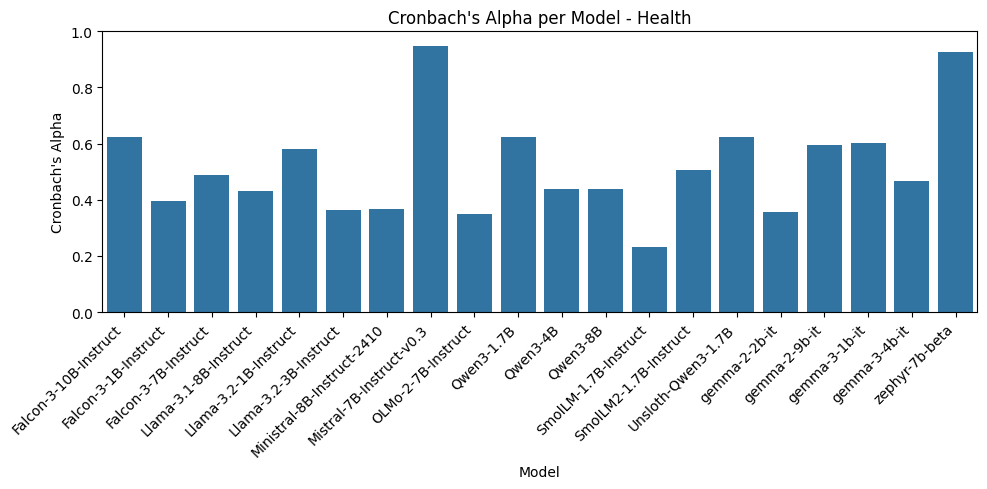

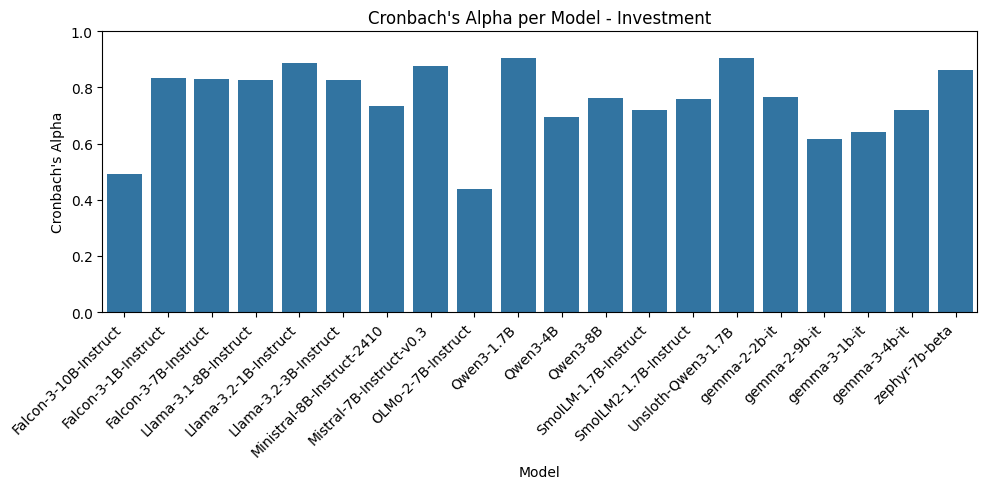

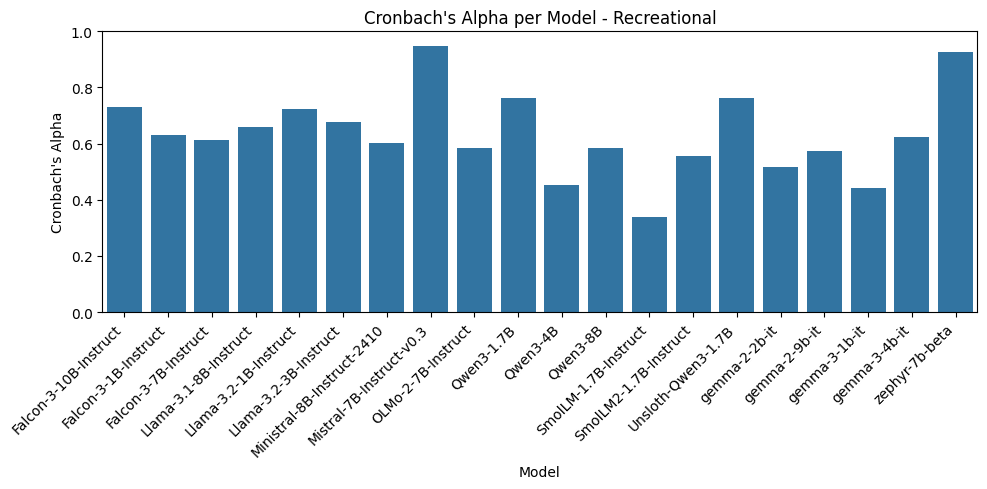

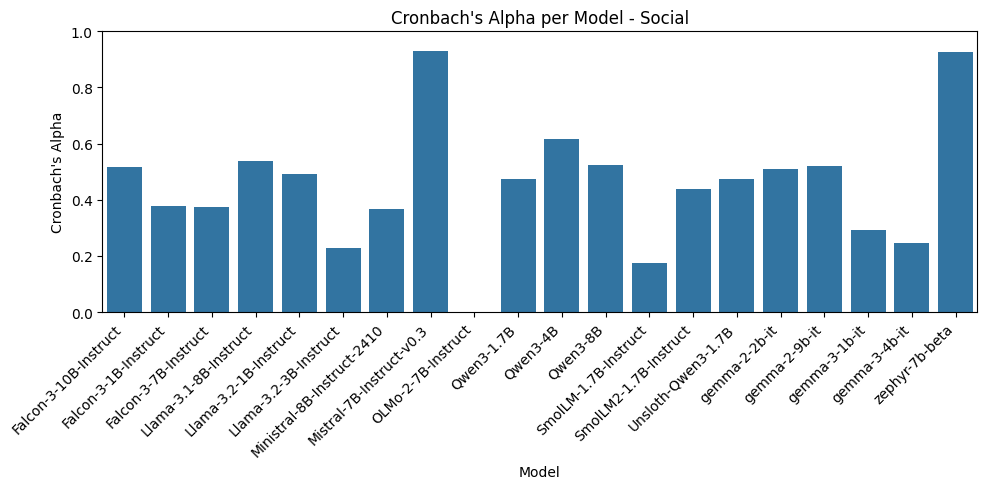

In [95]:
# loop through each domain and plot alphas per model
domains = alpha_df['domain'].unique()

for domain in domains:
    df_plot = alpha_df[alpha_df['domain'] == domain]
    
    plt.figure(figsize=(10,5))
    sns.barplot(data=df_plot, x='model', y='alpha')
    
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)  # Cronbach's alpha range
    plt.title(f"Cronbach's Alpha per Model - {domain}")
    plt.ylabel("Cronbach's Alpha")
    plt.xlabel("Model")
    
    # optionally, add CI as error bars if available
    if 'alpha_CI_lower' in df_plot.columns and 'alpha_CI_upper' in df_plot.columns:
        for i, row in df_plot.iterrows():
            plt.errorbar(
                x=i - df_plot.index.min(),  # bar position
                y=row['alpha'],
                yerr=[[row['alpha'] - row['alpha_CI_lower']], [row['alpha_CI_upper'] - row['alpha']]],
                fmt='none',
                c='black',
                capsize=3
            )
    
    plt.tight_layout()
    plt.show()


In [ ]:
# merged_dospert_data: long format with columns ['participant', 'item', 'model', 'logprob_predicted']

df_wide = merged_dospert_data.pivot_table(
    index=['model', 'participant'],
    columns='item',
    values='logprob_predicted'
).reset_index()

#df_wide: columns = wide format data with columns ['model', 'participant', item1, 2, ..., 40]

In [96]:
# ---- Cronbach's alpha full scale  ----
alphas = {}
alpha_ci = {}

for m, sub in df_wide.groupby("model"):
    scores = sub.drop(columns=["model", "participant"])
    alpha, ci = pg.cronbach_alpha(data=scores)

    alphas[m] = alpha
    alpha_ci[m] = ci

alpha_df = pd.DataFrame({
    "model": list(alphas.keys()),
    "alpha": list(alphas.values()),
    "alpha_CI": list(alpha_ci.values())
})

In [98]:
# ---- split-half reliability -----

def split_half_reliability(df_items, n_splits=100):
    """Compute average split-half reliability (Spearman–Brown corrected)."""
    k = df_items.shape[1]
    colnames = df_items.columns
    results = []
    
    for _ in range(n_splits):
        shuffled = list(colnames)
        random.shuffle(shuffled)
        half1, half2 = shuffled[:k//2], shuffled[k//2:]
        
        s1 = df_items[half1].sum(axis=1)
        s2 = df_items[half2].sum(axis=1)
        
        # Skip if constant
        if s1.nunique() <= 1 or s2.nunique() <= 1:
            continue

        r, _ = pearsonr(s1, s2)
        if np.isfinite(r): 
            r_sb = (2 * r) / (1 + r)
            results.append(r_sb)
    
    if results:
        return np.mean(results), np.std(results)
    else:
        return np.nan, np.nan  # No valid splits
    
split_results = {}

for m, sub in df_wide.groupby("model"):
    items = sub.drop(columns=["model", "participant"])
    mean_rsb, sd_rsb = split_half_reliability(items)
    split_results[m] = (mean_rsb, sd_rsb)

split_df = pd.DataFrame([
    {"model": m, "split_half_mean": mean, "split_half_sd": sd}
    for m, (mean, sd) in split_results.items()
])

In [113]:
# ---- ICC -----

df_long = merged_dospert_data.copy()

def compute_icc(df_long, model):
    """Compute ICC for one model (participant random effect)."""
    sub = df_long[df_long["model"] == model]
    if sub["logprob_predicted"].nunique() < 3:
        return np.nan  # or flag as unreliable
    # Random intercept model: logprob ~ 1 + (1|participant)
    md = mixedlm("logprob_predicted ~ 1", sub, groups=sub["participant"])
    try:
        mdf = md.fit(reml=True)
    except:
        return np.nan
    
    var_participant = mdf.cov_re.iloc[0,0]
    var_residual = mdf.scale
    icc = var_participant / (var_participant + var_residual)
    return icc

icc_results = {}
for m in df_long["model"].unique():
    icc_results[m] = compute_icc(df_long, m)

icc_df = pd.DataFrame(list(icc_results.items()), columns=["model", "icc"])


/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixe

In [114]:
results_df = alpha_df.merge(split_df, on="model").merge(icc_df, on="model")
results_df

,model,alpha,alpha_CI,split_half_mean,split_half_sd,icc
0,Falcon-3-10B-Instruct,0.901327,"[0.894, 0.908]",0.910184,0.014665,0.167611
1,Falcon-3-1B-Instruct,0.861366,"[0.851, 0.871]",0.872840,0.026321,0.123955
2,Falcon-3-7B-Instruct,0.875265,"[0.866, 0.884]",0.881145,0.022986,0.142060
3,Llama-3.1-8B-Instruct,0.871924,"[0.862, 0.881]",0.877092,0.019347,0.127542
4,Llama-3.2-1B-Instruct,0.908301,"[0.902, 0.915]",0.914194,0.016763,0.179038
5,Llama-3.2-3B-Instruct,0.863215,"[0.853, 0.873]",0.878849,0.017456,0.113893
6,Ministral-8B-Instruct-2410,0.823177,"[0.81, 0.836]",0.830352,0.021680,0.077902
7,Mistral-7B-Instruct-v0.3,0.987668,"[0.987, 0.989]",NaN,NaN,NaN
8,OLMo-2-7B-Instruct,0.612654,"[0.584, 0.64]",0.614208,0.094035,0.032431
9,Qwen3-1.7B,0.922970,"[0.917, 0.928]",0.938043,0.012789,0.219018


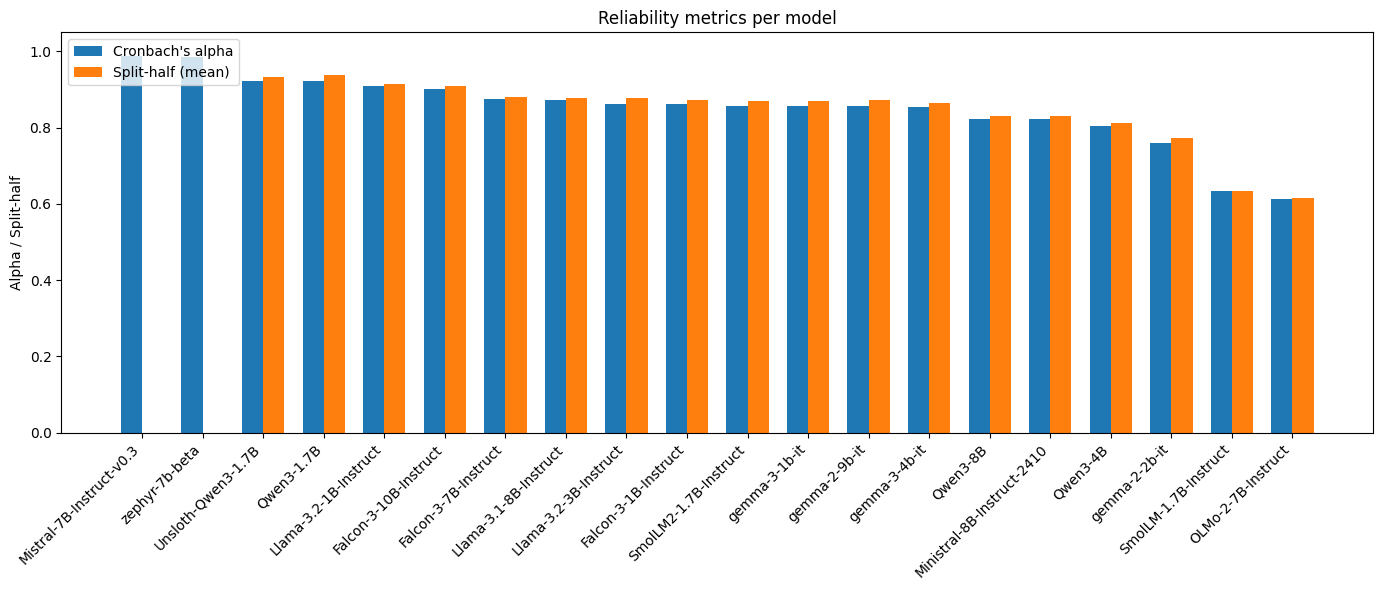

In [115]:
# Sort models by alpha for better readability
df_sorted = results_df.sort_values("alpha", ascending=False)

x = np.arange(len(df_sorted))  # positions for models
width = 0.35  # bar width

fig, ax1 = plt.subplots(figsize=(14,6))

# Bars for alpha and split-half
ax1.bar(x - width/2, df_sorted["alpha"], width, label="Cronbach's alpha")
ax1.bar(x + width/2, df_sorted["split_half_mean"], width, label="Split-half (mean)")

ax1.set_ylabel("Alpha / Split-half")
ax1.set_xticks(x)
ax1.set_xticklabels(df_sorted["model"], rotation=45, ha="right")
ax1.set_ylim(0, 1.05)
ax1.legend(loc="upper left")
ax1.set_title("Reliability metrics per model")

# Optional: plot ICC on secondary axis
# ax2 = ax1.twinx()
# ax2.plot(x, df_sorted["icc"], color="red", marker="o", linestyle='-', label="ICC")
# ax2.set_ylabel("ICC")
# ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


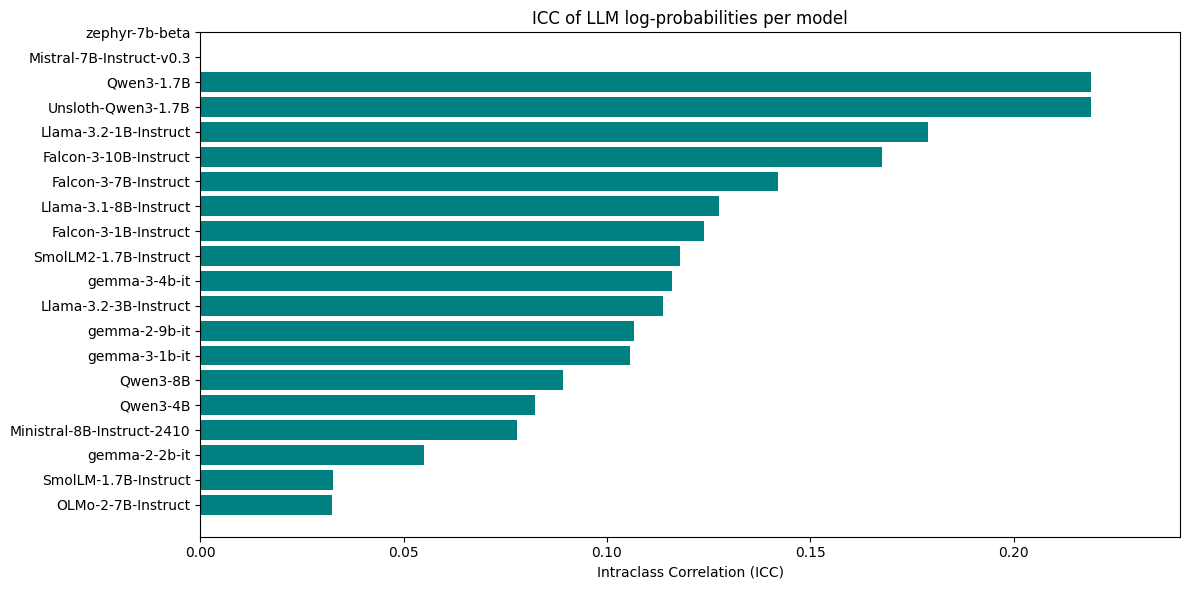

In [116]:
# Sort models by ICC for easier visualization
icc_sorted = results_df.sort_values("icc", ascending=True)
y = np.arange(len(icc_sorted))

plt.figure(figsize=(12,6))
plt.barh(y, icc_sorted["icc"], color="teal")
plt.yticks(y, icc_sorted["model"])
plt.xlabel("Intraclass Correlation (ICC)")
plt.title("ICC of LLM log-probabilities per model")
plt.xlim(0, icc_sorted["icc"].max()*1.1)  # add 10% padding
plt.tight_layout()
plt.show()

#ICC quantifies the proportion of variance in the LLM’s assigned log-probabilities that is attributable to differences between participants, as opposed to random variation across items or noise.

## Analyses on Human Data only

In [76]:
# ----- measure reliability of DOSPERT responses in humans ------------

# extract human answers
human_data = merged_dospert_data[merged_dospert_data["model"] == "Mistral-7B-Instruct-v0.3"]
#human_data = human_data[human_data["flipped"] == "no"]

#human_data = human_data[["participant", "human_number", "item"]]
human_data

# Identify flipped rows again
flip_mask = human_data['flipped'] == 'yes'

# Flip them back
human_data.loc[flip_mask, "human_number"] = 6 - human_data.loc[flip_mask, "human_number"]

# to wide format for analyses
df_wide_human = human_data.pivot_table(
    index=['participant'],
    columns='item',
    values='human_number'
).reset_index()


# ---- Cronbach's alpha ----
df_wide_human_without_participant_id = df_wide_human.drop(columns=["participant"])
pg.cronbach_alpha(df_wide_human_without_participant_id)


(0.8810453592185342, array([0.872, 0.889]))

In [77]:
# --- Calculate human cronbachs alpha divided by domain ---
# dictionary to store results
alphas = {}

# loop through domains
for domain, domain_data in human_data.groupby("domain"):
    # pivot wide format for this domain
    df_wide = domain_data.pivot_table(
        index="participant",
        columns="item",
        values="human_number"
    )
    # drop participant id if present
    df_wide = df_wide.dropna(axis=0)  # ensure no missing rows
    
    # calculate Cronbach's alpha
    alpha, ci = pg.cronbach_alpha(df_wide)
    
    alphas[domain] = {"alpha": alpha, "ci": ci}

alphas


{'Ethical': {'alpha': 0.785718737394081, 'ci': array([0.769, 0.802])},
 'Gambling': {'alpha': 0.7716849767368072, 'ci': array([0.752, 0.79 ])},
 'Health': {'alpha': 0.6852888367275239, 'ci': array([0.661, 0.709])},
 'Investment': {'alpha': 0.8213228655960135, 'ci': array([0.806, 0.836])},
 'Recreational': {'alpha': 0.8096413201624088, 'ci': array([0.795, 0.824])},
 'Social': {'alpha': 0.5784425933661972, 'ci': array([0.545, 0.61 ])}}

In [78]:
# ---- overall DOSPERT score per participant (all items) ----
overall = (
    human_data
    .groupby("participant")["human_number"]
    .mean()
    .rename("DOSPERT")
)

# ---- mean per domain ----
domains = (
    human_data
    .groupby(["participant", "domain"])["human_number"]
    .mean()
    .unstack()   # wide format: one column per domain
)

# optional: rename domains to short labels
domains = domains.rename(columns={
    "Investment": "Dinv",
    "Gambling": "Dgam",
    "Health": "Dhea",
    "Recreational": "Drec",
    "Social": "Dsoc", 
    "Ethical": "Deth"
})

# ---- merge overall + domains into one dataframe ----
scores = pd.concat([overall, domains], axis=1).reset_index()

scores.head(20)


,participant,DOSPERT,Deth,Dgam,Dhea,Dinv,Drec,Dsoc
0,64000401,2.750,2.250,1.00,3.500,1.00,3.375,3.625
1,64004701,2.600,2.250,1.00,3.625,1.75,2.875,2.875
2,64006401,2.750,3.125,1.00,3.875,1.00,2.500,3.250
3,64006901,2.450,1.375,1.25,2.875,2.75,2.500,3.500
4,64007901,2.400,1.500,1.00,2.500,3.00,2.875,3.125
5,64008701,2.000,1.250,1.75,1.625,2.25,2.000,3.125
6,64011501,2.950,2.875,1.25,3.750,1.00,2.875,4.125
7,64015601,1.825,1.250,1.00,1.750,1.75,1.750,3.000
8,64016901,2.875,2.750,2.50,2.500,3.50,2.875,3.250
9,64018301,1.900,1.750,1.00,1.625,2.00,1.625,3.000


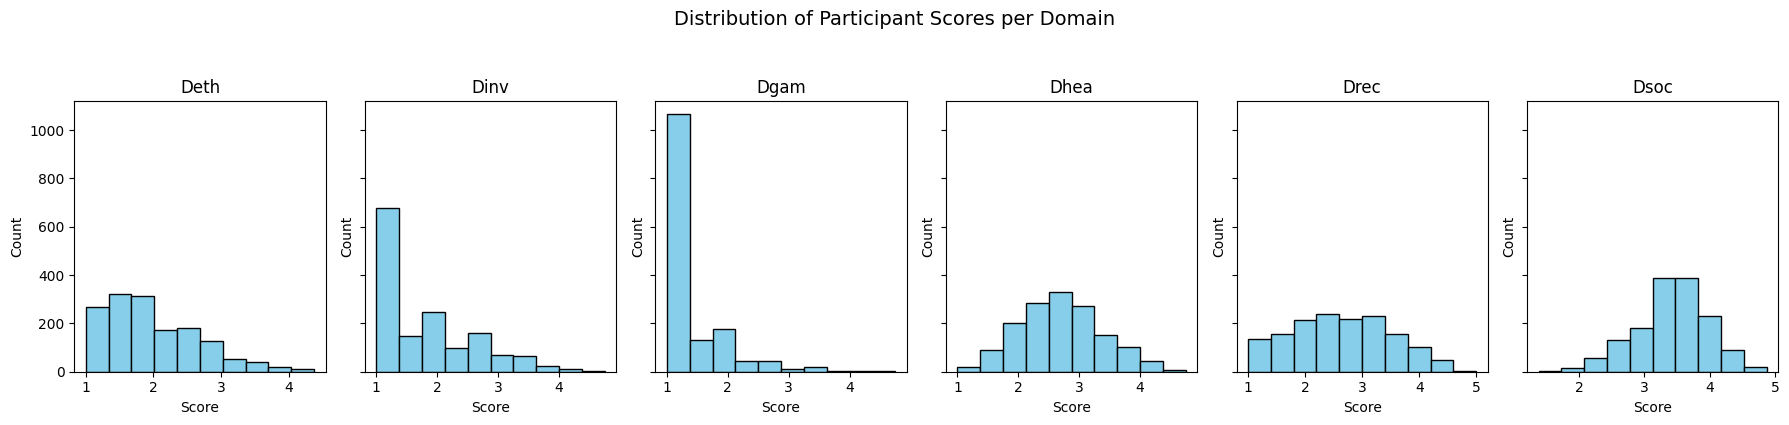

In [79]:
# compute group mean per domain
domains = ["Deth", "Dinv", "Dgam", "Dhea", "Drec", "Dsoc"]

fig, axes = plt.subplots(1, len(domains), figsize=(18,4), sharey=True)

for ax, dom in zip(axes, domains):
    ax.hist(scores[dom], bins=10, color="skyblue", edgecolor="black")
    ax.set_title(dom)
    ax.set_xlabel("Score")
    ax.set_ylabel("Count")

plt.suptitle("Distribution of Participant Scores per Domain", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()
